In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)
DATA_DIR = r"C:\Users\LENOVO\Downloads\CropWeedProject\dataset\train" 

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Classes found: {class_names}")

Found 2465 files belonging to 2 classes.
Using 1972 files for training.
Found 2465 files belonging to 2 classes.
Using 493 files for validation.
Classes found: ['crop', 'weed']


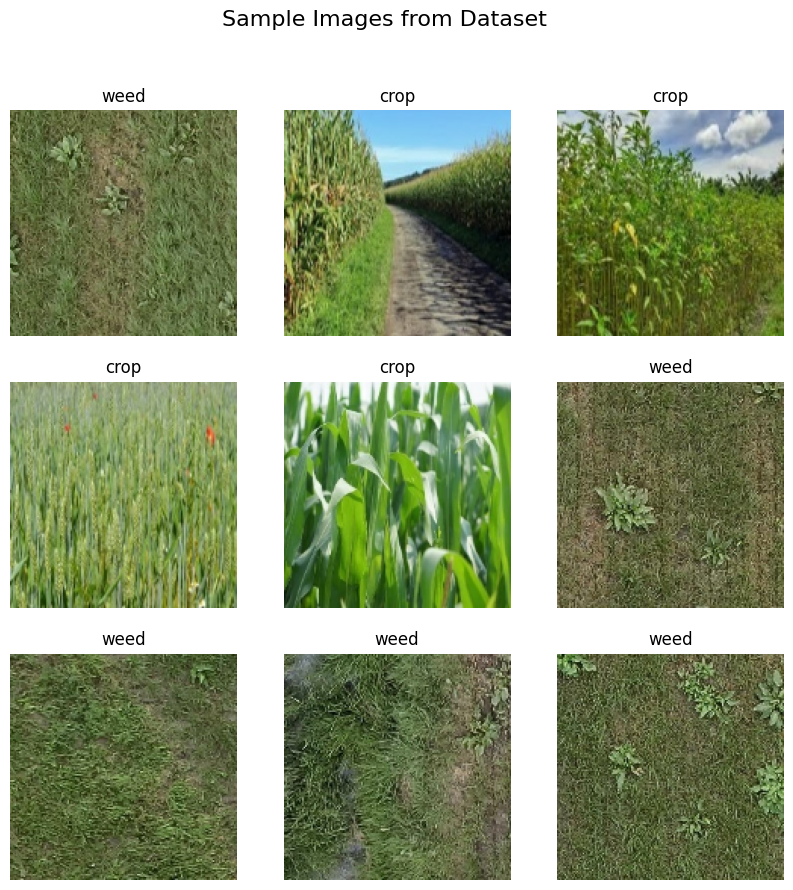

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Convert tensor to numpy and cast to int for display
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.show()

In [3]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Binary classification (Crop vs Weed)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25
)

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.9026 - loss: 13.0596 - val_accuracy: 0.9959 - val_loss: 0.0118
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - accuracy: 0.8524 - loss: 0.8616 - val_accuracy: 0.9878 - val_loss: 0.0344
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.9625 - loss: 0.1768 - val_accuracy: 0.9959 - val_loss: 0.0120
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.9949 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 365ms/step - accuracy: 0.9980 - loss: 0.0084 - val_accuracy: 0.9736 - val_loss: 0.0727
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9949 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9980 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.9990 - loss: 0.0046 - val_acc

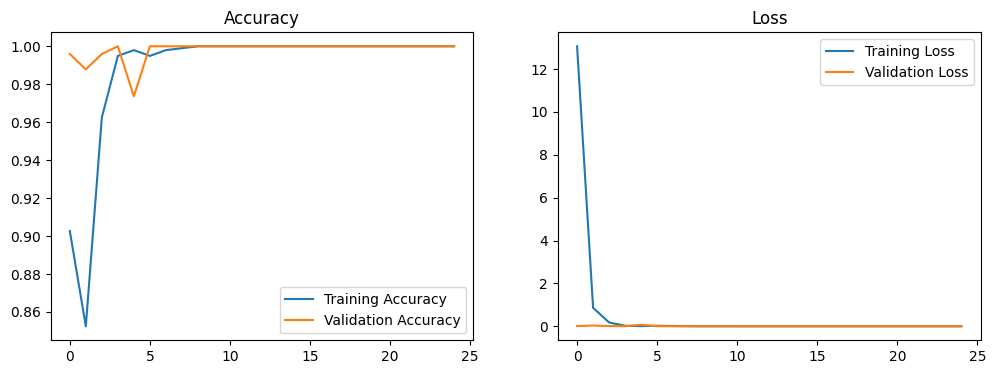

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
              precision    recall  f1-score   support

        Crop       1.00      1.00      1.00       163
        Weed       1.00      1.00      1.00       330

    accuracy                           1.00       493
   macro avg       1.00      1.00      1.00       493
weighted avg       1.00      1.00      1.00       493



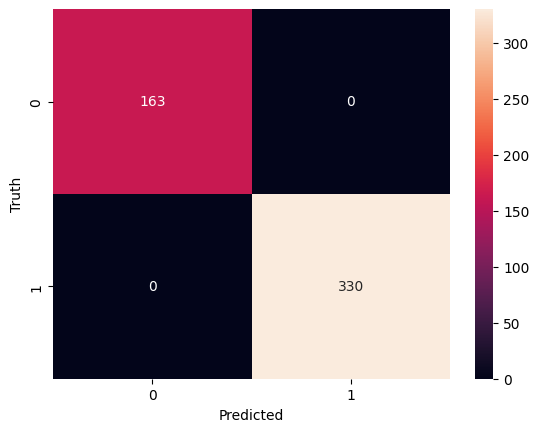

In [12]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p > 0.5 else 0 for p in preds])

# Metrics
print(classification_report(y_true, y_pred, target_names=['Crop', 'Weed']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [13]:
model.save('../models/crop_weed_model.h5')
print("Model saved to models/crop_weed_model.h5")

Model saved to models/crop_weed_model.h5



--- Running Single Image Prediction Test ---
Testing against a Weed image...


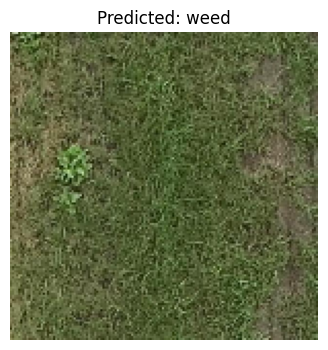

Testing against a Crop image...


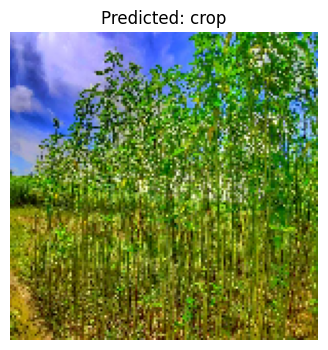

In [14]:
# Final Evaluation and Test

def predict_local_image(model, img_path, class_names):
    """
    Loads a single image, preprocesses it, and makes a prediction.
    """
    if not os.path.exists(img_path):
        print(f"Error: Test image not found at {img_path}")
        return

    # 1. Load and Preprocess Image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalization matching training

    # 2. Predict
    prediction = model.predict(img_array, verbose=0)
    score = float(prediction[0][0])
    
    # 3. Interpret Result (assuming 0=Crop, 1=Weed)
    if score > 0.5:
        label_index = 1
        confidence = score
    else:
        label_index = 0
        confidence = 1.0 - score
        
    predicted_label = class_names[label_index]

    # 4. Display Result
    plt.figure(figsize=(4, 4))
    plt.imshow(img.convert("RGB"))
    plt.title(f"Predicted: {predicted_label}")
    plt.xlabel(f"Confidence: {confidence * 100:.2f}%")
    plt.axis("off")
    plt.show()


# --- EXECUTE A TEST ---
print("\n--- Running Single Image Prediction Test ---")

# You MUST find a sample image path from your test or train folder 
# and paste it here for the notebook to run the demonstration.
TEST_IMAGE_PATH_WEED = r'C:\Users\LENOVO\Downloads\CropWeedProject\dataset\test\weed\ridderzuring_4516_jpg.rf.456b309daa219ed4121309cce3314125.jpg' 
TEST_IMAGE_PATH_CROP = r'C:\Users\LENOVO\Downloads\CropWeedProject\dataset\test\crop\jute-field.jpg' 

# Note: You must ensure these files exist in your data/test folders!

# Test 1: Predict a Weed
print("Testing against a Weed image...")
predict_local_image(model, TEST_IMAGE_PATH_WEED, class_names)

# Test 2: Predict a Crop
print("Testing against a Crop image...")
predict_local_image(model, TEST_IMAGE_PATH_CROP, class_names)